<a href="https://colab.research.google.com/github/lyapunovExponentGood/Modeling-Time-Dependencies-In-Medical-Data/blob/main/SeizuresVs_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following code reads in the InterseizureInterval.csv data file, giving us a vector of interseizure intervals (ISIs). We partition the sample ISI time series into two segments that appear to be generated by fundamentally different functions, and consider only the first one. The code partitions the ISI data into training and test data (currently 75% of the data is used for training and 25% for testing). Here the our primary regressors are d-dimensional time delay embeddings of the ISIs, where each point is a vector of d consecutive ISIs. The network is trained to predict the (d+1)st ISI from this sequence of d ISIs.

The neural network used here is tensorflow's feedforward neural network. 

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import math as mth
import seaborn as sns

from tensorflow import keras
from keras import layers, models, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [ ]:
def disjointTimeEmbedding(array, d, n):
  m = mth.floor(n/(d+1)) #number of embeddings + correct one forecast into the future predictions 
  embeddings = np.zeros([m,d])
  answers = np.zeros([m,1])

  indx=0
  for i in range(0,m):
    embeddings[i,0:d] = array[0,indx:indx+d]
    #print('index: ',i)
    answers[i,0] = array[0,(indx+d)]
    indx = indx+d+1 #yields disjoint embeddings so that the values the nn is predicting do not show up in the input data 



  return[embeddings, answers, d, m]

In [ ]:
#Generates surrogate datasets for H0: the null hypothesis of the data being independently and identically distributed
#Does do by permuting the indicies 
def Bootstrap(array,n): 
  #generate surrogate time series by uniformly scrambling the original time series
  #thus destroying any affect of temporal order 
  bootstraps = np.zeros((n, len(array)))
  for i in range (0,n):
    permute = np.random.permutation(array)
    bootstraps[i, 0:len(array)] = permute[0:len(array),0]

  return(bootstraps)

In [ ]:
#the following code reads in the SortedInterSeizureInterval.csv file 
#ISIs are already parsed and sorted 
import csv

file = open('SortedInterSeizureInterval.csv')
csvreader = csv.reader(file)
ISI = np.zeros((2613, 1))

for i in range(0, 2613):
  nextRow = next(csvreader)
  ISI[i] = float(nextRow[0])

print(ISI)

[[ 2.91666667]
 [ 3.99305556]
 [ 2.98611111]
 ...
 [16.98055556]
 [19.        ]
 [17.96319444]]


In [ ]:
#divide up sample time series
ISI1 = ISI[0:np.argmax(ISI)-1] #pre brain surgery
ISI2 = ISI[2345:len(ISI)] #post brain surgery

#bootstraps for comparison
randomISI1 = Bootstrap(ISI1, 1) #scramble the time series to destroy any affect of temporal order
randomISI1 = np.transpose(randomISI1)

In [ ]:
#choose time series to learn
array = ISI1
#array = randomISI1

In [ ]:
#Set Hyperparameters
n = len(array)
d = 3 #embedding dimension

proportionTraining = 0.75 #percentage of our data that will be used to train the network (remaining quantity is test data)
proportionValidation= 0.1 #percentage of our test data that will be used to validate the network during training

In [ ]:
trainArray = np.zeros((1,mth.floor(n*proportionTraining)))
trainArray = np.transpose(array[0:mth.floor(n*proportionTraining)]) 

[embeddingsX, answersX, dX, mX] = disjointTimeEmbedding(trainArray, d, proportionTraining*n) 

In [ ]:
testArray = np.transpose(array[mth.floor(proportionTraining*n):n])
[embeddingsTestX, answersTestX, dTest, mTestX] = disjointTimeEmbedding(testArray, d, mth.floor(n-proportionTraining*n))

In [ ]:
#the purpose of the concatenate is to format the data when we have more than one vector of predictors
#not relevant now but this will be helpful when we start incorporating other regressors

inputs = np.concatenate([embeddingsX,], axis =1)
correctOutputs = np.concatenate([answersX,], axis=1)

inputsTest = np.concatenate([embeddingsTestX, ], axis = 1)
correctTestOutputs = np.concatenate([answersTestX, ], axis = 1)

In [ ]:
print(np.shape(inputs))
print(np.shape(inputsTest))

(430, 3)
(143, 3)


In [ ]:
#Note: Do NOT use the Keras embedding layer as this casts double inputs to integers-
#which throws away a LOT of information
#However, do store data in a tensor since that is the input format the RNN expects

dimsIn = np.shape(inputs)
dimsInTest = np.shape(inputsTest)

rowsIn = dimsIn[0]
colsIn = dimsIn[1]

rowsInTest = dimsInTest[0]
colsInTest = dimsInTest[1]

inputTensor = np.zeros((rowsIn, colsIn, 1))
inputTensor[0:rowsIn, 0:colsIn, 0] = inputs

inputsTestTensor = np.zeros((rowsInTest, colsInTest, 1))
inputsTestTensor[0:rowsIn, 0:colsIn, 0] = inputsTest

In [ ]:
#RNN: 
tf.random.set_seed(7) # set random seek for the sake of consistency between tests 
rnn = Sequential()

#rnn.add(Dropout(0.1)) #10% chance of an input being set to zero to regularize and prevent overfitting
#rnn.add(layers.SimpleRNN(units = 256, return_sequences=True))
#rnn.add(layers.SimpleRNN(units = 128))
rnn.add(layers.LSTM(units = 256, return_sequences = True))
rnn.add(layers.LSTM(units = 128))
#rnn.add(Dense(units = 64, activation = 'sigmoid', input_dim = 1))
#rnn.add(Dense(units = 32, activation = 'sigmoid', input_dim = 1))
#rnn.add(Dense(units = 16, activation = 'sigmoid', input_dim = 1))
#rnn.add(Dense(units = 8, activation = 'sigmoid', input_dim = 1))
#rnn.add(Dense(units = 8, activation = 'sigmoid', input_dim = 1))
rnn.add(Dense(units = 1, activation = 'linear', input_dim = 1))  

#checkpoint = keras.callbacks.ModelCheckpoint("SeizuresRNN", save_best_only=True) #Allows us to view training stats
rnn.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=['mse'])

#10% of training data used for validation
#history = rnn.fit(inputTensor, correctOutputs, batch_size=len(inputTensor), epochs=500, callbacks=[checkpoint], validation_split=proportionValidation, shuffle=False)
rnn.fit(inputTensor, correctOutputs, batch_size=50, epochs=800, shuffle=True)

Epoch 1/800
9/9 [==============================] - 5s 30ms/step - loss: 0.4458 - mse: 0.4458
Epoch 2/800
9/9 [==============================] - 0s 29ms/step - loss: 0.4093 - mse: 0.4093
Epoch 3/800
9/9 [==============================] - 0s 29ms/step - loss: 0.4002 - mse: 0.4002
Epoch 4/800
9/9 [==============================] - 0s 32ms/step - loss: 0.3916 - mse: 0.3916
Epoch 5/800
9/9 [==============================] - 0s 29ms/step - loss: 0.3984 - mse: 0.3984
Epoch 6/800
9/9 [==============================] - 0s 28ms/step - loss: 0.3936 - mse: 0.3936
Epoch 7/800
9/9 [==============================] - 0s 29ms/step - loss: 0.3913 - mse: 0.3913
Epoch 8/800
9/9 [==============================] - 0s 31ms/step - loss: 0.3922 - mse: 0.3922
Epoch 9/800
9/9 [==============================] - 0s 29ms/step - loss: 0.3905 - mse: 0.3905
Epoch 10/800
9/9 [==============================] - 0s 30ms/step - loss: 0.3891 - mse: 0.3891
Epoch 11/800
9/9 [==============================] - 0s 30ms/step - lo

In [ ]:
#rnn.evaluate(inputsTest, correctTestOutputs)

In [ ]:
'''
#Plot the convergence of our MSE

model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["mse"], label="Training MSE")
ax.plot(np.arange(0, num_epochs), model_history["val_mse"], 
        label="Validation MSE")
ax.legend()

plt.tight_layout()
plt.show()
'''

'\n#Plot the convergence of our MSE\n\nmodel_history = pd.DataFrame(history.history)\nmodel_history[\'epoch\'] = history.epoch\n\nfig, ax = plt.subplots(1, figsize=(8,6))\nnum_epochs = model_history.shape[0]\n\nax.plot(np.arange(0, num_epochs), model_history["mse"], label="Training MSE")\nax.plot(np.arange(0, num_epochs), model_history["val_mse"], \n        label="Validation MSE")\nax.legend()\n\nplt.tight_layout()\nplt.show()\n'

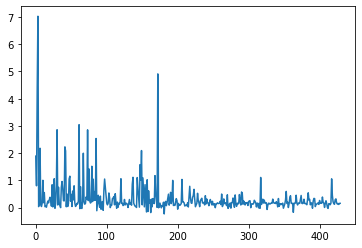

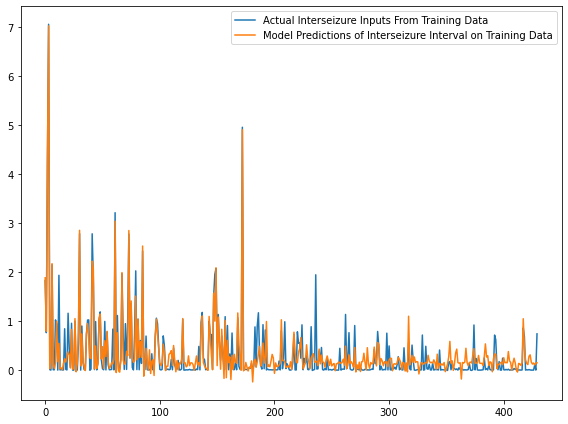

In [ ]:
model = rnn.predict(inputTensor)
plt.plot(model)
#plt.plot(correctOutputs)

fig, modelPlot = plt.subplots(1, figsize=(8,6))

modelPlot.plot(correctOutputs, label="Actual Interseizure Inputs From Training Data")
modelPlot.plot(model, label="Model Predictions of Interseizure Interval on Training Data")

modelPlot.legend()

plt.tight_layout()
plt.show()

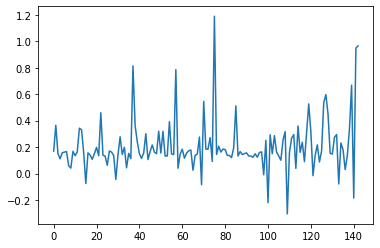

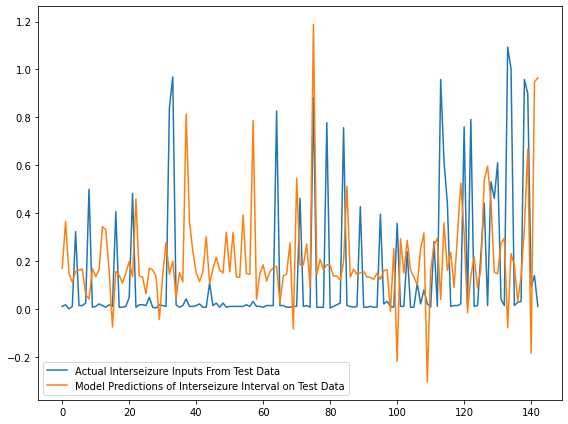

In [ ]:
y_pred = rnn.predict(inputsTestTensor)
plt.plot(y_pred)

fig, predictPlot = plt.subplots(1, figsize=(8,6))

predictPlot.plot(correctTestOutputs, label="Actual Interseizure Inputs From Test Data")
predictPlot.plot(y_pred, label="Model Predictions of Interseizure Interval on Test Data")

predictPlot.legend()

plt.tight_layout()
plt.show()


In [ ]:
y_predCorrected = abs(y_pred)

In [ ]:
#without correcting for degrees of freedom loss 
#because the test data is never used to estimate any parameters so no degrees of freedom lost

def MSE(predicted, actual):
  m = len(predicted)
  y_error = (1/(m)*np.sum(np.square(predicted - actual), axis=0))
  return y_error

In [ ]:
#percent of variance explained by the model
def VarianceExplained(predicted, actual):
    predError = MSE(predicted, actual)
    totalError = np.var(actual)

    errorExplained = (totalError - predError)

    percentVarianceExplained = errorExplained/totalError

    return percentVarianceExplained

In [ ]:
y_error = MSE(y_pred, correctTestOutputs)
print(y_error)

[0.10440583]


In [ ]:
VarianceExplained(y_pred, correctTestOutputs)

array([-0.29075064])

In [ ]:
'''
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["mae"], 
        label="Training MAE")
ax.plot(np.arange(0, num_epochs), model_history["val_mae"], 
        label="Validation MAE")
ax.legend()

plt.tight_layout()
plt.show()
'''

In [ ]:
#sns.scatterplot(data=x, x='Longitude', y='Latitude', size=y, alpha=0.5, hue=y, palette='magma')